# CW04 Part 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

In [2]:
def angular_spectrum_propagation_free_space(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U1  : the propagated field

    Implemented according to: 
    Matsushima, Kyoji, and Tomoyoshi Shimobaba. 
    "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." 
    Optics express 17.22 (2009): 19662-19673.
    """

    # Get the shape of the original array
    original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2
    # Create a new array filled with zeros with the target shape
    U0_padded = np.zeros((original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype)
    # Place the original array in the center of the new array
    U0_padded[pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0
    
    # Get array size
    ny, nx = U0_padded.shape
    # Wave number
    k = 2 * np.pi / wvl 

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)

    Delta_uy =  1 / (ny * dx)
    Delta_ux =  1 / (nx * dx)
    u_limity = 1 / (np.sqrt((2 * Delta_uy * z)**2 + 1) * wvl)
    u_limitx = 1 / (np.sqrt((2 * Delta_ux * z)**2 + 1) * wvl)
    H_limit = W = ((FY**2 / u_limity**2 + FX**2 * wvl**2) < 1) * ((FX**2 / u_limitx**2 + FY**2 * wvl**2) < 1)
    # Kernel
    H = np.exp(1j * k * z * np.sqrt(0j + 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # propagate
    U1_padded = np.fft.fftshift(np.fft.ifft2(np.fft.fft2(np.fft.ifftshift(U0_padded)) * H * H_limit))
    # extract to initial size
    U1 = U1_padded[pad_height:pad_height + original_height, pad_width:pad_width + original_width]
          
    return U1


In [3]:
def lens_propagate(U0, wvl, dx, focal_length):
    """
    Propagates an optical field from one focal_length in front of the lens to one focal_length behind the lens
    
    Parameters:
    U0      : 2D numpy array (input wavefield)
    wvl     : float (wavelength of light in meters)
    dx      :  float (sampling interval in meters)
    focal_length : float (focal length of the lens)
    
    Returns:
    U1  : the propagated field
    """
    L_half_x = dx * U0.shape[1] / 2
    L_half_y = dx * U0.shape[0] / 2

    x = np.linspace(-L_half_x, L_half_x, U0.shape[1], endpoint=False)
    y = np.linspace(-L_half_y, L_half_y, U0.shape[0], endpoint=False)

    X, Y = np.meshgrid(x,y)

    k = 2 * np.pi / wvl
    lens = np.exp(-1j * k / 2 / focal_length * (X**2 + Y**2))
    
    prop = lambda U: angular_spectrum_propagation_free_space(U, wvl, dx, focal_length)

    U_final = prop(lens * prop(U0))

    return U_final

# Dark Field Microscope

You are given a compex initial field.

The wavelength is `633nm` with a pixel size of `1µm`. 

Propagate field through a 4F system with focal length of `2mm`.
Use a round aperture of radius `300µm` in the Fourier plane.

1. Show the final result.

2. Show the final result if you include a small hole in the round aperture of radius `10µm`.

## 1.

In [13]:
U0 = np.load("cells_example.npy")

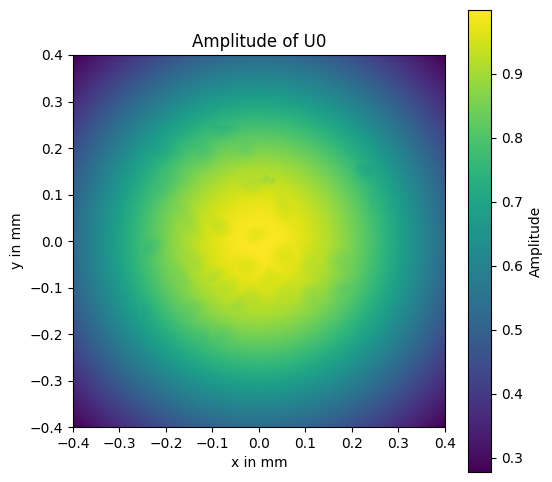

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(U0), extent=[-L_half_x * 1000, L_half_x * 1000, -L_half_y * 1000, L_half_y * 1000])
plt.colorbar(label="Amplitude")
plt.xlabel("x in mm")
plt.ylabel("y in mm")
plt.title("Amplitude of U0")
plt.show()

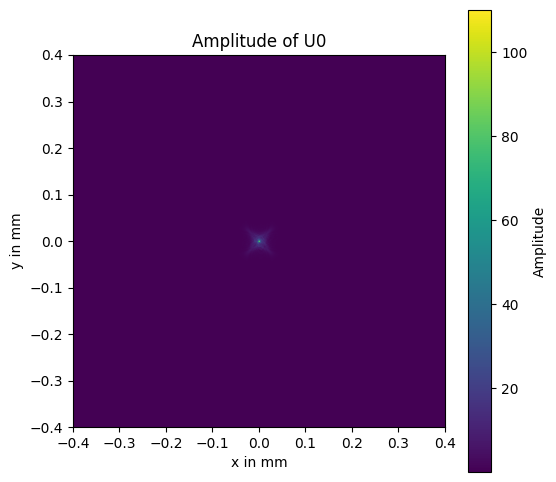

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(lens_propagate(U0, 633e-9, 1e-6, 1e-3))**1, extent=[-L_half_x * 1000, L_half_x * 1000, -L_half_y * 1000, L_half_y * 1000])
plt.colorbar(label="Amplitude")
plt.xlabel("x in mm")
plt.ylabel("y in mm")
plt.title("Amplitude of U0")
plt.show()

In [16]:
aperture_full = ((X**2 + Y**2) < (300e-6)**2) * 1.0

In [17]:
U1 = lens_propagate(U0, 633e-9, 1e-6, 2e-3)
U2 = lens_propagate(U1 * aperture_full, 633e-9, 1e-6, 2e-3)

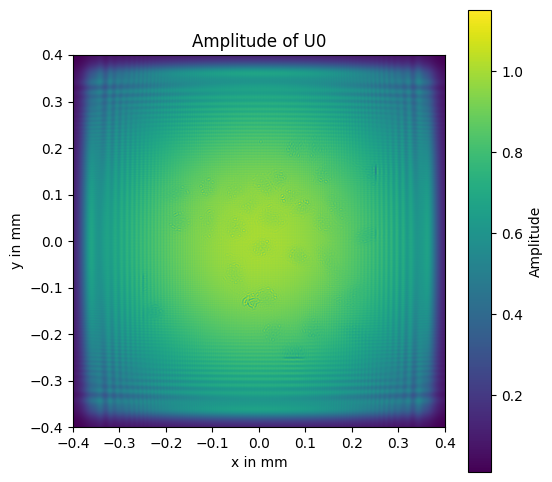

In [18]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(U2), extent=[-L_half_x * 1000, L_half_x * 1000, -L_half_y * 1000, L_half_y * 1000])
plt.colorbar(label="Amplitude")
plt.xlabel("x in mm")
plt.ylabel("y in mm")
plt.title("Amplitude of U0")
plt.show()

## 2.

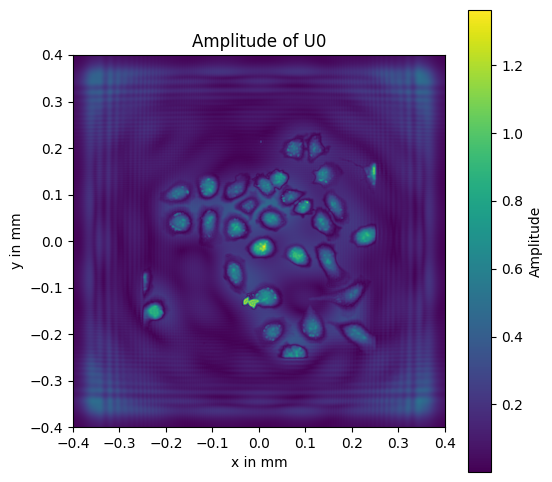

In [19]:
aperture_full = ((X**2 + Y**2) < (300e-6)**2) * 1.0
aperture_small = ((X**2 + Y**2) < (10e-6)**2) * 1.0

aperture = aperture_full - aperture_small

U1 = lens_propagate(U0, 633e-9, 1e-6, 2e-3)
U2 = lens_propagate(U1 * aperture, 633e-9, 1e-6, 2e-3)

plt.figure(figsize=(6,6))
plt.imshow(np.abs(U2), extent=[-L_half_x * 1000, L_half_x * 1000, -L_half_y * 1000, L_half_y * 1000])
plt.colorbar(label="Amplitude")
plt.xlabel("x in mm")
plt.ylabel("y in mm")
plt.title("Amplitude of U0")
plt.show()